### Imports


In [1]:
import torch 
import torch.nn.functional as F 

import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline

### Preparing a toy dataset

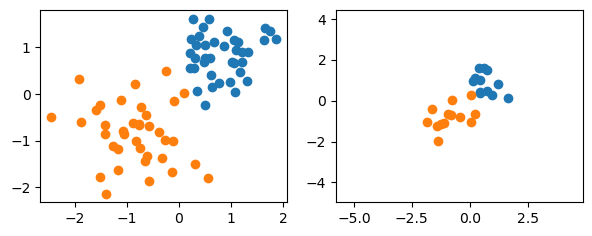

In [20]:
data = np.genfromtxt('toydata.txt' , delimiter = '\t')
x = data[ : , :2].astype(np.float32)
y = data[ : ,2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])  #creates a vector of 0 to 99 
np.random.shuffle(idx)  #shuffles idx, now shuffles idx is in idx 

#Making the train - test split 
X_test , y_test = x[idx[:25]] , y[idx[:25]]
X_train , y_train = x[idx[25:]] , y[idx[25:]]

#Normalizing 
mu , sigma = np.mean(X_train , axis = 0 ) , np.std(X_train , axis = 0)
X_train , X_test = (X_train - mu)/sigma , (X_test-mu)/sigma

#Making plots of training and testing sets 

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

### Low level gradients with manual gradients 

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class LogisticRegression1():
    
    def __init__(self , num_features): 
        self.num_features = num_features 
        self.weights = torch.zeros( 1, num_features , dtype = torch.float32 , device = device)
        self.bias = torch.zeros(1 , dtype = torch.float32 , device = device)
    
    ##Net input and activation 
    
    def _sigmoid(self ,z):
        return 1./(1. + torch.exp(-z))    
    
    def forward(self , x): 
        linear = torch.add( torch.mm( x , self.weights.t()),self.bias)
        probas = self._sigmoid(linear)
        return probas 
   
    ##graidents and loss function calulation 
    def backward(self , x, y , probas): 
        grad_loss_wrt_z = probas.view(-1) - y 
        grad_loss_wrt_w = torch.mm( x.t(),grad_loss_wrt_z.view(-1,1)).t()
        grad_loss_wrt_b = torch.sum(grad_loss_wrt_z)
        return grad_loss_wrt_w , grad_loss_wrt_b
    
    ##Predicting classes 
    def predict_labels(self ,x): 
        probas = self.forward(x)
        labels = torch.where(probas >= .5 , 1, 0)
        return labels 
    
    ## Evaluating the model 
    def evaluate( self , x, y): 
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item()/y.size(0)  #item converts it to scalar 
        return accuracy
    
    def _logit_cost(self , y , proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba.view(-1, 1)))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba.view(-1, 1)))
        return tmp1 - tmp2
    
    def train(self , x, y , num_epochs , learning_rate = 0.01):
        epoch_cost = []
        
        for e in range(num_epochs):
            
            ##compute outputs###
            probas = self.forward(x)
            
            ##Compute gradients##
            grad_w , grad_b = self.backward(x ,y ,probas)
            
            ##Update weights##
            self.weights -= learning_rate * grad_w 
            self.weights -= learning_rate * grad_b 
            
            ####logging### 
            #### Logging ####
            cost = self._logit_cost(y, self.forward(x)) / x.size(0)
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % cost)
            epoch_cost.append(cost)
        return epoch_cost 

In [46]:
X_train_tensor = torch.tensor(X_train , dtype = torch.float32 , device = device)
y_train_tensor = torch.tensor(y_train , dtype = torch.float32 , device = device)


model1 = LogisticRegression1(num_features = 2)
epoch_cost = model1.train(X_train_tensor , y_train_tensor , num_epochs = 30 , learning_rate= 0.1)

print('\nModel Parameters: ')
print('  Weights: %s' %model1.weights)
print(" Bias : %s" %model1.weights)


Epoch: 001 | Train ACC: 0.973 | Cost: -0.054
Epoch: 002 | Train ACC: 0.973 | Cost: -0.054
Epoch: 003 | Train ACC: 0.973 | Cost: -0.054
Epoch: 004 | Train ACC: 0.973 | Cost: -0.054
Epoch: 005 | Train ACC: 0.973 | Cost: -0.055
Epoch: 006 | Train ACC: 0.973 | Cost: -0.055
Epoch: 007 | Train ACC: 0.973 | Cost: -0.055
Epoch: 008 | Train ACC: 0.973 | Cost: -0.055
Epoch: 009 | Train ACC: 0.973 | Cost: -0.055
Epoch: 010 | Train ACC: 0.973 | Cost: -0.055
Epoch: 011 | Train ACC: 0.973 | Cost: -0.056
Epoch: 012 | Train ACC: 0.973 | Cost: -0.056
Epoch: 013 | Train ACC: 0.973 | Cost: -0.056
Epoch: 014 | Train ACC: 0.973 | Cost: -0.056
Epoch: 015 | Train ACC: 0.973 | Cost: -0.056
Epoch: 016 | Train ACC: 0.973 | Cost: -0.056
Epoch: 017 | Train ACC: 0.973 | Cost: -0.056
Epoch: 018 | Train ACC: 0.973 | Cost: -0.056
Epoch: 019 | Train ACC: 0.973 | Cost: -0.056
Epoch: 020 | Train ACC: 0.973 | Cost: -0.057
Epoch: 021 | Train ACC: 0.973 | Cost: -0.057
Epoch: 022 | Train ACC: 0.973 | Cost: -0.057
Epoch: 023

Evaluating the Model 

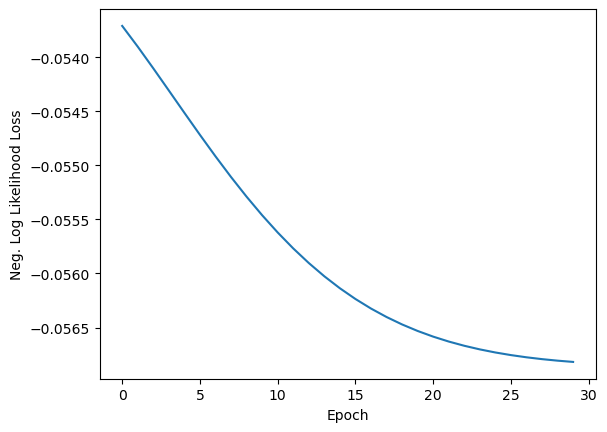

In [47]:
plt.plot(epoch_cost)
plt.ylabel('Neg. Log Likelihood Loss')
plt.xlabel('Epoch')
plt.show()

In [42]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = model1.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 96.00%


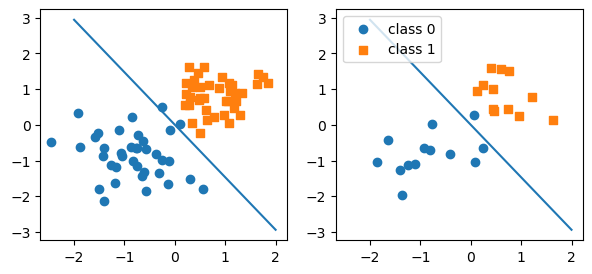

In [43]:


##########################
### 2D Decision Boundary
##########################

w, b = model1.weights.view(-1), model1.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()



High level implementation using nn.Module API 

In [52]:
class LogisticRegression2(torch.nn.Module):
    def __init__(self , num_features): 
        super(LogisticRegression2 ,self).__init__()
        self.linear = torch.nn.Linear(num_features ,1) #calulate net input 
        #initialize weight to 0
        #_ implies inplace operation
               
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self , x): 
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas 
    
model2 = LogisticRegression2( num_features = 2).to(device)
optimizer = torch.optim.SGD(model2.parameters() , lr = 0.1)
         

In [56]:
def comp_accuracy(label_var , pred_probas): 
    pred_labels= torch.where((pred_probas >= 0.5 ), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float()/label_var.size(0)
    return acc
num_epochs = 30 

X_train_tensor = torch.tensor(X_train, dtype = torch.float32 , device = device)
y_train_tensor = torch.tensor(y_train , dtype = torch.float32 , device = device).view(-1,1)

for e in range(num_epochs):
    ##Comput outputs
    out = model2(X_train_tensor)
    
    ##Compute gradients
    loss = F.binary_cross_entropy(out , y_train_tensor , reduction = 'sum')
    optimizer.zero_grad()
    loss.backward()
    
    ###Update weights 
    optimizer.step()
    
    ####LOgging###
    pred_probas = model2(X_train_tensor)
    acc = comp_accuracy(y_train_tensor , pred_probas)
    print('Epoch: %03d' % (e + 1) , end = "") 
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))
    
print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 001 | Train ACC: 0.973 | Cost: 0.053
Epoch: 002 | Train ACC: 0.973 | Cost: 0.051
Epoch: 003 | Train ACC: 0.973 | Cost: 0.049
Epoch: 004 | Train ACC: 0.973 | Cost: 0.048
Epoch: 005 | Train ACC: 0.973 | Cost: 0.047
Epoch: 006 | Train ACC: 0.973 | Cost: 0.046
Epoch: 007 | Train ACC: 0.973 | Cost: 0.045
Epoch: 008 | Train ACC: 0.973 | Cost: 0.044
Epoch: 009 | Train ACC: 0.987 | Cost: 0.043
Epoch: 010 | Train ACC: 0.987 | Cost: 0.042
Epoch: 011 | Train ACC: 0.987 | Cost: 0.041
Epoch: 012 | Train ACC: 0.987 | Cost: 0.041
Epoch: 013 | Train ACC: 0.987 | Cost: 0.040
Epoch: 014 | Train ACC: 0.987 | Cost: 0.039
Epoch: 015 | Train ACC: 0.987 | Cost: 0.039
Epoch: 016 | Train ACC: 1.000 | Cost: 0.038
Epoch: 017 | Train ACC: 1.000 | Cost: 0.038
Epoch: 018 | Train ACC: 1.000 | Cost: 0.037
Epoch: 019 | Train ACC: 1.000 | Cost: 0.036
Epoch: 020 | Train ACC: 1.000 | Cost: 0.036
Epoch: 021 | Train ACC: 1.000 | Cost: 0.036
Epoch: 022 | Train ACC: 1.000 | Cost: 0.035
Epoch: 023 | Train ACC: 1.000 | 

In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model2(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('Test set accuracy: %.2f%%' % (test_acc*100))